# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

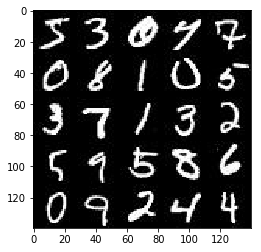

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

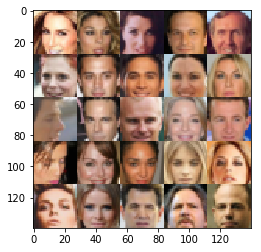

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs')
    z_vector = tf.placeholder(tf.float32, (None, z_dim), name='z_vector')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs, z_vector, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    l_relu = lambda x: tf.maximum(alpha * x, x)
    
    def convolution(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return l_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = convolution(images, 64, batch_norm=False) 
        x2 = convolution(x1, 128) 
        x3 = convolution(x2, 256) 
        
        logits = tf.layers.dense(tf.reshape(x3, (-1, 4*4*256)), 1)
        output = tf.sigmoid(logits)

        return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def trans_conv2d(input_layer, num_filters, training, activation=True, alpha=0.2):
    
    l_relu = lambda x, alpha: tf.maximum(alpha * x, x)
    conv_layer = tf.layers.conv2d_transpose(input_layer, num_filters, 3, strides=2, padding='same')
    conv_layer = tf.layers.batch_normalization(conv_layer, training=training)
    if activation:
        return l_relu(conv_layer, alpha)
    else:
        return conv_layer

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*32)
        layer = tf.reshape(layer, (-1, 7, 7, 32))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        
        layer_1 = trans_conv2d(layer, 16, training=is_train)
        
        layer_2 = trans_conv2d(layer_1, out_channel_dim, training=is_train, activation=None)
        output = tf.nn.tanh(layer_2)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g = generator(input_z, out_channel_dim)
    
    d_real, d_logits_real = discriminator(input_real)
    d_fake, d_logits_fake = discriminator(g, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    coll = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(coll):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.0967... Generator Loss: 10.1999
Epoch 1/2... Batch 20... Discriminator Loss: 0.0080... Generator Loss: 14.8418
Epoch 1/2... Batch 30... Discriminator Loss: 0.0048... Generator Loss: 8.0878
Epoch 1/2... Batch 40... Discriminator Loss: 0.0063... Generator Loss: 6.7004
Epoch 1/2... Batch 50... Discriminator Loss: 0.0014... Generator Loss: 7.8283
Epoch 1/2... Batch 60... Discriminator Loss: 0.0039... Generator Loss: 7.4889
Epoch 1/2... Batch 70... Discriminator Loss: 1.2956... Generator Loss: 1.5145
Epoch 1/2... Batch 80... Discriminator Loss: 0.0580... Generator Loss: 3.6564
Epoch 1/2... Batch 90... Discriminator Loss: 0.0566... Generator Loss: 3.5459
Epoch 1/2... Batch 100... Discriminator Loss: 0.6751... Generator Loss: 2.4312


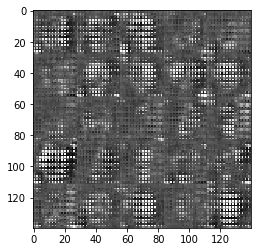

Epoch 1/2... Batch 110... Discriminator Loss: 0.0249... Generator Loss: 6.1943
Epoch 1/2... Batch 120... Discriminator Loss: 0.0774... Generator Loss: 4.4661
Epoch 1/2... Batch 130... Discriminator Loss: 0.0006... Generator Loss: 9.5851
Epoch 1/2... Batch 140... Discriminator Loss: 0.0496... Generator Loss: 4.2410
Epoch 1/2... Batch 150... Discriminator Loss: 0.4253... Generator Loss: 5.6441
Epoch 1/2... Batch 160... Discriminator Loss: 1.2473... Generator Loss: 0.7487
Epoch 1/2... Batch 170... Discriminator Loss: 0.9645... Generator Loss: 1.2036
Epoch 1/2... Batch 180... Discriminator Loss: 0.4415... Generator Loss: 3.5518
Epoch 1/2... Batch 190... Discriminator Loss: 0.1490... Generator Loss: 3.4188
Epoch 1/2... Batch 200... Discriminator Loss: 1.2570... Generator Loss: 0.6994


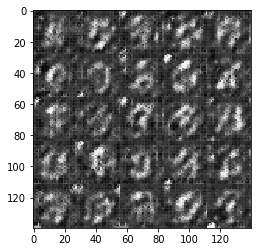

Epoch 1/2... Batch 210... Discriminator Loss: 0.8509... Generator Loss: 1.9604
Epoch 1/2... Batch 220... Discriminator Loss: 0.5973... Generator Loss: 1.4847
Epoch 1/2... Batch 230... Discriminator Loss: 0.2117... Generator Loss: 2.1630
Epoch 1/2... Batch 240... Discriminator Loss: 0.0890... Generator Loss: 3.0847
Epoch 1/2... Batch 250... Discriminator Loss: 0.1219... Generator Loss: 2.8463
Epoch 1/2... Batch 260... Discriminator Loss: 0.0439... Generator Loss: 4.3221
Epoch 1/2... Batch 270... Discriminator Loss: 9.8320... Generator Loss: 10.8701
Epoch 1/2... Batch 280... Discriminator Loss: 1.3621... Generator Loss: 1.6503
Epoch 1/2... Batch 290... Discriminator Loss: 0.2581... Generator Loss: 1.7569
Epoch 1/2... Batch 300... Discriminator Loss: 0.0549... Generator Loss: 3.8161


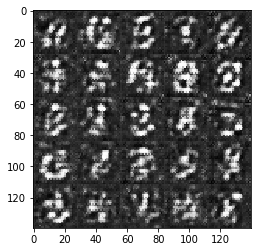

Epoch 1/2... Batch 310... Discriminator Loss: 0.3876... Generator Loss: 1.4681
Epoch 1/2... Batch 320... Discriminator Loss: 0.3459... Generator Loss: 1.9747
Epoch 1/2... Batch 330... Discriminator Loss: 0.0652... Generator Loss: 4.2473
Epoch 1/2... Batch 340... Discriminator Loss: 0.0165... Generator Loss: 4.8569
Epoch 1/2... Batch 350... Discriminator Loss: 0.0242... Generator Loss: 4.3375
Epoch 1/2... Batch 360... Discriminator Loss: 0.0147... Generator Loss: 5.1592
Epoch 1/2... Batch 370... Discriminator Loss: 0.0186... Generator Loss: 4.9049
Epoch 1/2... Batch 380... Discriminator Loss: 0.0205... Generator Loss: 4.7793
Epoch 1/2... Batch 390... Discriminator Loss: 0.0236... Generator Loss: 4.6090
Epoch 1/2... Batch 400... Discriminator Loss: 0.0188... Generator Loss: 4.8478


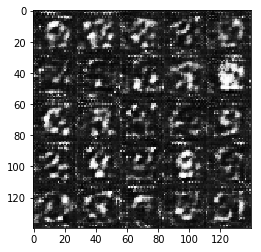

Epoch 1/2... Batch 410... Discriminator Loss: 0.0112... Generator Loss: 5.0002
Epoch 1/2... Batch 420... Discriminator Loss: 0.0150... Generator Loss: 4.7309
Epoch 1/2... Batch 430... Discriminator Loss: 0.0162... Generator Loss: 4.7208
Epoch 1/2... Batch 440... Discriminator Loss: 0.0159... Generator Loss: 4.8768
Epoch 1/2... Batch 450... Discriminator Loss: 0.0099... Generator Loss: 5.5343
Epoch 1/2... Batch 460... Discriminator Loss: 0.0073... Generator Loss: 5.7359
Epoch 1/2... Batch 470... Discriminator Loss: 0.0066... Generator Loss: 5.9597
Epoch 1/2... Batch 480... Discriminator Loss: 0.7286... Generator Loss: 1.4801
Epoch 1/2... Batch 490... Discriminator Loss: 0.7749... Generator Loss: 2.6184
Epoch 1/2... Batch 500... Discriminator Loss: 0.3089... Generator Loss: 2.0890


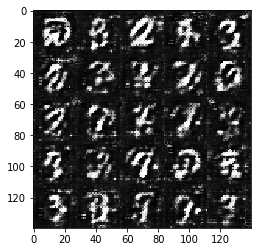

Epoch 1/2... Batch 510... Discriminator Loss: 6.5502... Generator Loss: 0.0028
Epoch 1/2... Batch 520... Discriminator Loss: 0.3345... Generator Loss: 2.2772
Epoch 1/2... Batch 530... Discriminator Loss: 0.3758... Generator Loss: 2.5309
Epoch 1/2... Batch 540... Discriminator Loss: 0.4037... Generator Loss: 1.5847
Epoch 1/2... Batch 550... Discriminator Loss: 0.6114... Generator Loss: 1.1539
Epoch 1/2... Batch 560... Discriminator Loss: 0.6171... Generator Loss: 0.9448
Epoch 1/2... Batch 570... Discriminator Loss: 0.3143... Generator Loss: 1.8208
Epoch 1/2... Batch 580... Discriminator Loss: 0.1200... Generator Loss: 4.0185
Epoch 1/2... Batch 590... Discriminator Loss: 0.4561... Generator Loss: 1.9644
Epoch 1/2... Batch 600... Discriminator Loss: 1.1386... Generator Loss: 5.0574


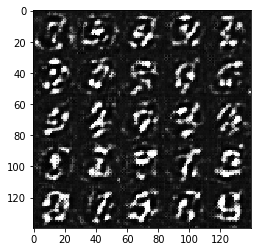

Epoch 1/2... Batch 610... Discriminator Loss: 0.1945... Generator Loss: 2.4281
Epoch 1/2... Batch 620... Discriminator Loss: 2.8699... Generator Loss: 4.9487
Epoch 1/2... Batch 630... Discriminator Loss: 0.7519... Generator Loss: 2.2607
Epoch 1/2... Batch 640... Discriminator Loss: 0.4252... Generator Loss: 1.8527
Epoch 1/2... Batch 650... Discriminator Loss: 0.3431... Generator Loss: 2.2024
Epoch 1/2... Batch 660... Discriminator Loss: 0.2133... Generator Loss: 2.1691
Epoch 1/2... Batch 670... Discriminator Loss: 0.0752... Generator Loss: 3.3664
Epoch 1/2... Batch 680... Discriminator Loss: 0.1742... Generator Loss: 2.3660
Epoch 1/2... Batch 690... Discriminator Loss: 0.0456... Generator Loss: 4.0199
Epoch 1/2... Batch 700... Discriminator Loss: 0.0528... Generator Loss: 3.6614


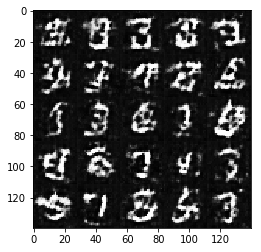

Epoch 1/2... Batch 710... Discriminator Loss: 0.6079... Generator Loss: 1.5165
Epoch 1/2... Batch 720... Discriminator Loss: 0.5421... Generator Loss: 2.0244
Epoch 1/2... Batch 730... Discriminator Loss: 0.2880... Generator Loss: 2.4336
Epoch 1/2... Batch 740... Discriminator Loss: 0.1775... Generator Loss: 2.1683
Epoch 1/2... Batch 750... Discriminator Loss: 0.1458... Generator Loss: 2.6399
Epoch 1/2... Batch 760... Discriminator Loss: 3.4017... Generator Loss: 10.0805
Epoch 1/2... Batch 770... Discriminator Loss: 0.1905... Generator Loss: 2.5351
Epoch 1/2... Batch 780... Discriminator Loss: 0.4418... Generator Loss: 1.3605
Epoch 1/2... Batch 790... Discriminator Loss: 0.1081... Generator Loss: 3.1631
Epoch 1/2... Batch 800... Discriminator Loss: 0.1813... Generator Loss: 2.4474


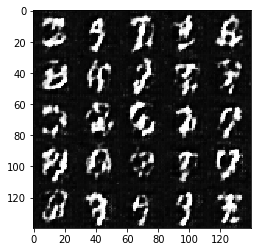

Epoch 1/2... Batch 810... Discriminator Loss: 0.0818... Generator Loss: 3.6542
Epoch 1/2... Batch 820... Discriminator Loss: 1.3179... Generator Loss: 0.6981
Epoch 1/2... Batch 830... Discriminator Loss: 0.9123... Generator Loss: 0.9768
Epoch 1/2... Batch 840... Discriminator Loss: 0.5485... Generator Loss: 1.3748
Epoch 1/2... Batch 850... Discriminator Loss: 0.6180... Generator Loss: 1.1613
Epoch 1/2... Batch 860... Discriminator Loss: 1.5508... Generator Loss: 0.6239
Epoch 1/2... Batch 870... Discriminator Loss: 0.7717... Generator Loss: 2.6615
Epoch 1/2... Batch 880... Discriminator Loss: 0.4024... Generator Loss: 1.8833
Epoch 1/2... Batch 890... Discriminator Loss: 0.4571... Generator Loss: 1.7720
Epoch 1/2... Batch 900... Discriminator Loss: 0.5028... Generator Loss: 2.8138


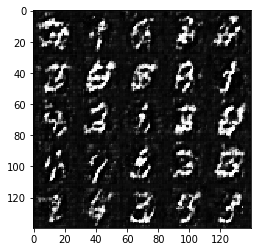

Epoch 1/2... Batch 910... Discriminator Loss: 0.5661... Generator Loss: 1.3179
Epoch 1/2... Batch 920... Discriminator Loss: 0.3340... Generator Loss: 2.2307
Epoch 1/2... Batch 930... Discriminator Loss: 0.5326... Generator Loss: 1.4580
Epoch 2/2... Batch 10... Discriminator Loss: 0.4593... Generator Loss: 1.7389
Epoch 2/2... Batch 20... Discriminator Loss: 1.3362... Generator Loss: 0.5728
Epoch 2/2... Batch 30... Discriminator Loss: 0.4557... Generator Loss: 1.5328
Epoch 2/2... Batch 40... Discriminator Loss: 2.5160... Generator Loss: 0.2435
Epoch 2/2... Batch 50... Discriminator Loss: 0.4827... Generator Loss: 1.5313
Epoch 2/2... Batch 60... Discriminator Loss: 0.5049... Generator Loss: 1.3819
Epoch 2/2... Batch 70... Discriminator Loss: 0.2551... Generator Loss: 2.0417
Epoch 2/2... Batch 80... Discriminator Loss: 0.4682... Generator Loss: 2.1968
Epoch 2/2... Batch 90... Discriminator Loss: 0.2497... Generator Loss: 2.1351
Epoch 2/2... Batch 100... Discriminator Loss: 0.3348... Gener

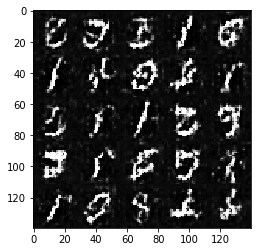

Epoch 2/2... Batch 110... Discriminator Loss: 0.1723... Generator Loss: 2.6532
Epoch 2/2... Batch 120... Discriminator Loss: 0.0770... Generator Loss: 4.6097
Epoch 2/2... Batch 130... Discriminator Loss: 0.2184... Generator Loss: 2.2844
Epoch 2/2... Batch 140... Discriminator Loss: 0.1112... Generator Loss: 3.8347
Epoch 2/2... Batch 150... Discriminator Loss: 0.6629... Generator Loss: 1.3358
Epoch 2/2... Batch 160... Discriminator Loss: 0.4600... Generator Loss: 1.4113
Epoch 2/2... Batch 170... Discriminator Loss: 0.3168... Generator Loss: 1.8832
Epoch 2/2... Batch 180... Discriminator Loss: 0.3031... Generator Loss: 2.1586
Epoch 2/2... Batch 190... Discriminator Loss: 0.2238... Generator Loss: 2.4464
Epoch 2/2... Batch 200... Discriminator Loss: 0.0548... Generator Loss: 4.0160


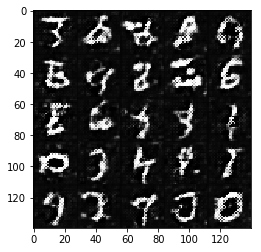

Epoch 2/2... Batch 210... Discriminator Loss: 6.8223... Generator Loss: 15.1260
Epoch 2/2... Batch 220... Discriminator Loss: 0.7779... Generator Loss: 1.5823
Epoch 2/2... Batch 230... Discriminator Loss: 0.6410... Generator Loss: 1.2566
Epoch 2/2... Batch 240... Discriminator Loss: 0.3717... Generator Loss: 1.9424
Epoch 2/2... Batch 250... Discriminator Loss: 0.1862... Generator Loss: 3.4516
Epoch 2/2... Batch 260... Discriminator Loss: 0.2378... Generator Loss: 2.8390
Epoch 2/2... Batch 270... Discriminator Loss: 1.0268... Generator Loss: 0.9554
Epoch 2/2... Batch 280... Discriminator Loss: 0.4669... Generator Loss: 2.2821
Epoch 2/2... Batch 290... Discriminator Loss: 0.3110... Generator Loss: 1.7530
Epoch 2/2... Batch 300... Discriminator Loss: 0.2690... Generator Loss: 2.3426


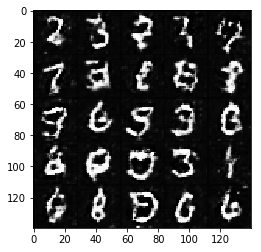

Epoch 2/2... Batch 310... Discriminator Loss: 0.2765... Generator Loss: 1.9325
Epoch 2/2... Batch 320... Discriminator Loss: 0.4617... Generator Loss: 1.9631
Epoch 2/2... Batch 330... Discriminator Loss: 0.3817... Generator Loss: 1.6287
Epoch 2/2... Batch 340... Discriminator Loss: 0.3154... Generator Loss: 1.9231
Epoch 2/2... Batch 350... Discriminator Loss: 0.2433... Generator Loss: 2.1159
Epoch 2/2... Batch 360... Discriminator Loss: 0.1020... Generator Loss: 3.2415
Epoch 2/2... Batch 370... Discriminator Loss: 0.1135... Generator Loss: 3.1976
Epoch 2/2... Batch 380... Discriminator Loss: 0.1038... Generator Loss: 3.2732
Epoch 2/2... Batch 390... Discriminator Loss: 7.4492... Generator Loss: 0.0062
Epoch 2/2... Batch 400... Discriminator Loss: 0.4715... Generator Loss: 1.9096


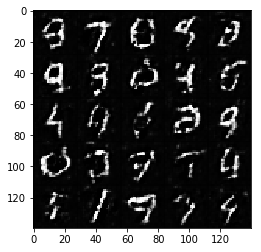

Epoch 2/2... Batch 410... Discriminator Loss: 0.2532... Generator Loss: 2.1315
Epoch 2/2... Batch 420... Discriminator Loss: 0.2051... Generator Loss: 2.3273
Epoch 2/2... Batch 430... Discriminator Loss: 0.2455... Generator Loss: 2.1273
Epoch 2/2... Batch 440... Discriminator Loss: 0.1668... Generator Loss: 2.7076
Epoch 2/2... Batch 450... Discriminator Loss: 0.0669... Generator Loss: 3.7365
Epoch 2/2... Batch 460... Discriminator Loss: 1.2795... Generator Loss: 3.4369
Epoch 2/2... Batch 470... Discriminator Loss: 0.5873... Generator Loss: 1.4883
Epoch 2/2... Batch 480... Discriminator Loss: 0.3088... Generator Loss: 2.3188
Epoch 2/2... Batch 490... Discriminator Loss: 0.3746... Generator Loss: 2.1510
Epoch 2/2... Batch 500... Discriminator Loss: 0.2972... Generator Loss: 2.0773


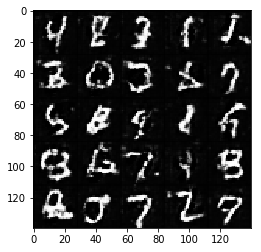

Epoch 2/2... Batch 510... Discriminator Loss: 0.4506... Generator Loss: 4.6151
Epoch 2/2... Batch 520... Discriminator Loss: 0.4660... Generator Loss: 1.4240
Epoch 2/2... Batch 530... Discriminator Loss: 0.2217... Generator Loss: 2.5052
Epoch 2/2... Batch 540... Discriminator Loss: 0.1969... Generator Loss: 2.7563
Epoch 2/2... Batch 550... Discriminator Loss: 0.1670... Generator Loss: 2.8293
Epoch 2/2... Batch 560... Discriminator Loss: 0.0723... Generator Loss: 4.1446
Epoch 2/2... Batch 570... Discriminator Loss: 0.1604... Generator Loss: 2.8069
Epoch 2/2... Batch 580... Discriminator Loss: 0.1951... Generator Loss: 2.8033
Epoch 2/2... Batch 590... Discriminator Loss: 0.1318... Generator Loss: 3.3752
Epoch 2/2... Batch 600... Discriminator Loss: 0.1269... Generator Loss: 3.2562


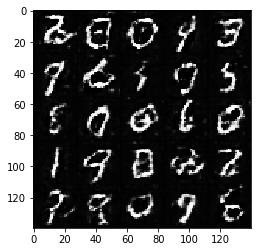

Epoch 2/2... Batch 610... Discriminator Loss: 0.1434... Generator Loss: 2.9110
Epoch 2/2... Batch 620... Discriminator Loss: 0.0903... Generator Loss: 3.3368
Epoch 2/2... Batch 630... Discriminator Loss: 0.4235... Generator Loss: 1.9077
Epoch 2/2... Batch 640... Discriminator Loss: 0.3484... Generator Loss: 3.2717
Epoch 2/2... Batch 650... Discriminator Loss: 0.6332... Generator Loss: 1.1433
Epoch 2/2... Batch 660... Discriminator Loss: 0.2294... Generator Loss: 2.8769
Epoch 2/2... Batch 670... Discriminator Loss: 0.2316... Generator Loss: 2.3508
Epoch 2/2... Batch 680... Discriminator Loss: 1.9166... Generator Loss: 0.3151
Epoch 2/2... Batch 690... Discriminator Loss: 0.2081... Generator Loss: 2.4418
Epoch 2/2... Batch 700... Discriminator Loss: 0.1765... Generator Loss: 3.2027


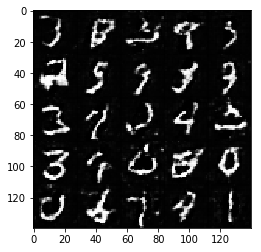

Epoch 2/2... Batch 710... Discriminator Loss: 0.3599... Generator Loss: 2.0646
Epoch 2/2... Batch 720... Discriminator Loss: 0.0796... Generator Loss: 3.5622
Epoch 2/2... Batch 730... Discriminator Loss: 0.0855... Generator Loss: 3.5768
Epoch 2/2... Batch 740... Discriminator Loss: 0.0590... Generator Loss: 4.3592
Epoch 2/2... Batch 750... Discriminator Loss: 0.0842... Generator Loss: 3.9540
Epoch 2/2... Batch 760... Discriminator Loss: 0.0302... Generator Loss: 4.4024
Epoch 2/2... Batch 770... Discriminator Loss: 0.0553... Generator Loss: 3.9813
Epoch 2/2... Batch 780... Discriminator Loss: 1.3914... Generator Loss: 0.5032
Epoch 2/2... Batch 790... Discriminator Loss: 0.3021... Generator Loss: 2.2881
Epoch 2/2... Batch 800... Discriminator Loss: 0.3794... Generator Loss: 1.8928


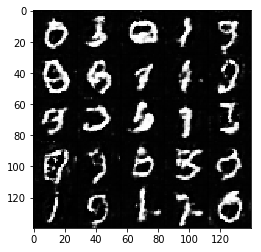

Epoch 2/2... Batch 810... Discriminator Loss: 0.2649... Generator Loss: 2.2231
Epoch 2/2... Batch 820... Discriminator Loss: 0.1442... Generator Loss: 3.2274
Epoch 2/2... Batch 830... Discriminator Loss: 0.1612... Generator Loss: 2.6128
Epoch 2/2... Batch 840... Discriminator Loss: 0.1265... Generator Loss: 2.8294
Epoch 2/2... Batch 850... Discriminator Loss: 0.1324... Generator Loss: 3.1162
Epoch 2/2... Batch 860... Discriminator Loss: 2.8031... Generator Loss: 0.1827
Epoch 2/2... Batch 870... Discriminator Loss: 0.2900... Generator Loss: 2.6287
Epoch 2/2... Batch 880... Discriminator Loss: 0.9070... Generator Loss: 0.8887
Epoch 2/2... Batch 890... Discriminator Loss: 0.2420... Generator Loss: 2.3006
Epoch 2/2... Batch 900... Discriminator Loss: 0.2350... Generator Loss: 2.3925


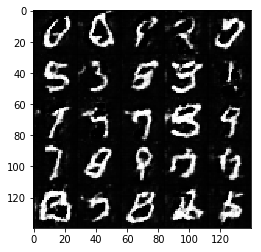

Epoch 2/2... Batch 910... Discriminator Loss: 0.2224... Generator Loss: 2.4718
Epoch 2/2... Batch 920... Discriminator Loss: 0.2565... Generator Loss: 2.2009
Epoch 2/2... Batch 930... Discriminator Loss: 0.2314... Generator Loss: 2.6418


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.0763... Generator Loss: 3.3169
Epoch 1/1... Batch 20... Discriminator Loss: 0.0345... Generator Loss: 3.9736
Epoch 1/1... Batch 30... Discriminator Loss: 0.0229... Generator Loss: 4.5415
Epoch 1/1... Batch 40... Discriminator Loss: 0.0128... Generator Loss: 4.9470
Epoch 1/1... Batch 50... Discriminator Loss: 0.0223... Generator Loss: 4.9346
Epoch 1/1... Batch 60... Discriminator Loss: 0.0099... Generator Loss: 5.3181
Epoch 1/1... Batch 70... Discriminator Loss: 0.0076... Generator Loss: 5.3263
Epoch 1/1... Batch 80... Discriminator Loss: 0.0076... Generator Loss: 5.4139
Epoch 1/1... Batch 90... Discriminator Loss: 0.0075... Generator Loss: 5.6775
Epoch 1/1... Batch 100... Discriminator Loss: 0.0093... Generator Loss: 5.6811


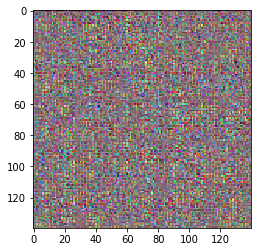

Epoch 1/1... Batch 110... Discriminator Loss: 0.0064... Generator Loss: 5.8026
Epoch 1/1... Batch 120... Discriminator Loss: 0.0037... Generator Loss: 6.1465
Epoch 1/1... Batch 130... Discriminator Loss: 0.0052... Generator Loss: 5.9062
Epoch 1/1... Batch 140... Discriminator Loss: 0.0042... Generator Loss: 6.3107
Epoch 1/1... Batch 150... Discriminator Loss: 0.0053... Generator Loss: 5.8547
Epoch 1/1... Batch 160... Discriminator Loss: 0.0041... Generator Loss: 5.9965
Epoch 1/1... Batch 170... Discriminator Loss: 0.0042... Generator Loss: 6.1931
Epoch 1/1... Batch 180... Discriminator Loss: 0.0026... Generator Loss: 6.5386
Epoch 1/1... Batch 190... Discriminator Loss: 0.0029... Generator Loss: 6.5390
Epoch 1/1... Batch 200... Discriminator Loss: 0.0022... Generator Loss: 6.6241


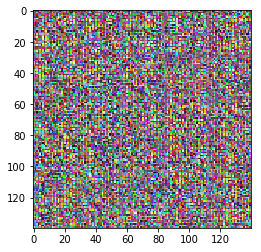

Epoch 1/1... Batch 210... Discriminator Loss: 0.0032... Generator Loss: 6.6116
Epoch 1/1... Batch 220... Discriminator Loss: 0.0025... Generator Loss: 6.3839
Epoch 1/1... Batch 230... Discriminator Loss: 0.0035... Generator Loss: 6.5494
Epoch 1/1... Batch 240... Discriminator Loss: 0.0021... Generator Loss: 6.7834
Epoch 1/1... Batch 250... Discriminator Loss: 0.0021... Generator Loss: 6.8546
Epoch 1/1... Batch 260... Discriminator Loss: 0.0015... Generator Loss: 6.8897
Epoch 1/1... Batch 270... Discriminator Loss: 0.0023... Generator Loss: 6.8883
Epoch 1/1... Batch 280... Discriminator Loss: 0.0025... Generator Loss: 6.8989
Epoch 1/1... Batch 290... Discriminator Loss: 0.0017... Generator Loss: 6.8785
Epoch 1/1... Batch 300... Discriminator Loss: 0.0016... Generator Loss: 6.9699


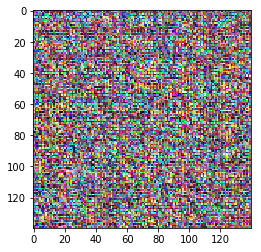

Epoch 1/1... Batch 310... Discriminator Loss: 0.0014... Generator Loss: 7.3087
Epoch 1/1... Batch 320... Discriminator Loss: 0.0018... Generator Loss: 7.4083
Epoch 1/1... Batch 330... Discriminator Loss: 0.0013... Generator Loss: 7.2269
Epoch 1/1... Batch 340... Discriminator Loss: 0.0010... Generator Loss: 7.4050
Epoch 1/1... Batch 350... Discriminator Loss: 0.0009... Generator Loss: 7.5721
Epoch 1/1... Batch 360... Discriminator Loss: 0.0010... Generator Loss: 7.5807
Epoch 1/1... Batch 370... Discriminator Loss: 0.0016... Generator Loss: 7.1823
Epoch 1/1... Batch 380... Discriminator Loss: 0.0012... Generator Loss: 7.2227
Epoch 1/1... Batch 390... Discriminator Loss: 0.0011... Generator Loss: 7.1719
Epoch 1/1... Batch 400... Discriminator Loss: 0.0011... Generator Loss: 7.3355


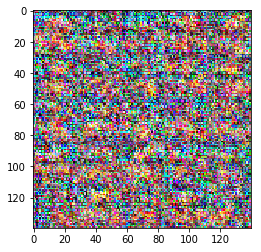

Epoch 1/1... Batch 410... Discriminator Loss: 0.0010... Generator Loss: 7.5289
Epoch 1/1... Batch 420... Discriminator Loss: 0.0011... Generator Loss: 7.4315
Epoch 1/1... Batch 430... Discriminator Loss: 0.0019... Generator Loss: 6.6582
Epoch 1/1... Batch 440... Discriminator Loss: 0.0009... Generator Loss: 7.8736
Epoch 1/1... Batch 450... Discriminator Loss: 0.0009... Generator Loss: 7.5116
Epoch 1/1... Batch 460... Discriminator Loss: 0.0006... Generator Loss: 7.9809
Epoch 1/1... Batch 470... Discriminator Loss: 0.0009... Generator Loss: 7.6785
Epoch 1/1... Batch 480... Discriminator Loss: 0.0012... Generator Loss: 7.5914
Epoch 1/1... Batch 490... Discriminator Loss: 0.0011... Generator Loss: 7.3900
Epoch 1/1... Batch 500... Discriminator Loss: 0.0009... Generator Loss: 7.5107


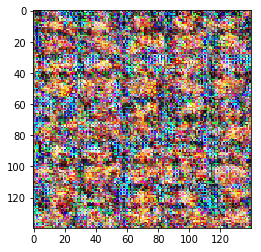

Epoch 1/1... Batch 510... Discriminator Loss: 0.0008... Generator Loss: 7.8405
Epoch 1/1... Batch 520... Discriminator Loss: 0.0008... Generator Loss: 7.9311
Epoch 1/1... Batch 530... Discriminator Loss: 0.0009... Generator Loss: 8.0491
Epoch 1/1... Batch 540... Discriminator Loss: 0.0010... Generator Loss: 7.6866
Epoch 1/1... Batch 550... Discriminator Loss: 0.0008... Generator Loss: 7.9123
Epoch 1/1... Batch 560... Discriminator Loss: 0.0014... Generator Loss: 7.5876
Epoch 1/1... Batch 570... Discriminator Loss: 0.0007... Generator Loss: 7.7305
Epoch 1/1... Batch 580... Discriminator Loss: 0.0008... Generator Loss: 7.9379
Epoch 1/1... Batch 590... Discriminator Loss: 0.0022... Generator Loss: 7.7353
Epoch 1/1... Batch 600... Discriminator Loss: 0.0013... Generator Loss: 7.3547


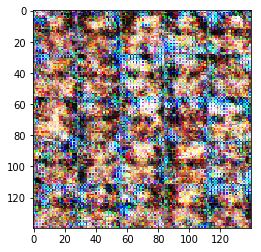

Epoch 1/1... Batch 610... Discriminator Loss: 0.0013... Generator Loss: 7.3210
Epoch 1/1... Batch 620... Discriminator Loss: 0.0007... Generator Loss: 7.7319
Epoch 1/1... Batch 630... Discriminator Loss: 0.0013... Generator Loss: 7.3868
Epoch 1/1... Batch 640... Discriminator Loss: 0.0019... Generator Loss: 7.3045
Epoch 1/1... Batch 650... Discriminator Loss: 0.0022... Generator Loss: 7.4090
Epoch 1/1... Batch 660... Discriminator Loss: 0.0012... Generator Loss: 7.6399
Epoch 1/1... Batch 670... Discriminator Loss: 0.0014... Generator Loss: 7.3939
Epoch 1/1... Batch 680... Discriminator Loss: 0.0021... Generator Loss: 7.3392
Epoch 1/1... Batch 690... Discriminator Loss: 0.0011... Generator Loss: 7.5255
Epoch 1/1... Batch 700... Discriminator Loss: 0.0021... Generator Loss: 6.8902


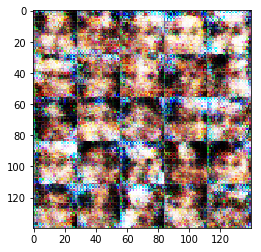

Epoch 1/1... Batch 710... Discriminator Loss: 0.0097... Generator Loss: 5.1979
Epoch 1/1... Batch 720... Discriminator Loss: 0.0014... Generator Loss: 7.5932
Epoch 1/1... Batch 730... Discriminator Loss: 0.0005... Generator Loss: 8.4288
Epoch 1/1... Batch 740... Discriminator Loss: 0.0011... Generator Loss: 8.0725
Epoch 1/1... Batch 750... Discriminator Loss: 0.0015... Generator Loss: 7.7151
Epoch 1/1... Batch 760... Discriminator Loss: 0.0007... Generator Loss: 8.0261
Epoch 1/1... Batch 770... Discriminator Loss: 0.0020... Generator Loss: 7.1487
Epoch 1/1... Batch 780... Discriminator Loss: 0.0011... Generator Loss: 8.0502
Epoch 1/1... Batch 790... Discriminator Loss: 0.0011... Generator Loss: 7.8360
Epoch 1/1... Batch 800... Discriminator Loss: 0.1598... Generator Loss: 4.9716


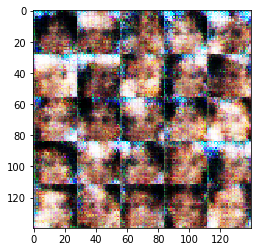

Epoch 1/1... Batch 810... Discriminator Loss: 0.0592... Generator Loss: 4.4960
Epoch 1/1... Batch 820... Discriminator Loss: 0.0390... Generator Loss: 4.9319
Epoch 1/1... Batch 830... Discriminator Loss: 0.0399... Generator Loss: 5.1516
Epoch 1/1... Batch 840... Discriminator Loss: 0.0181... Generator Loss: 5.2138
Epoch 1/1... Batch 850... Discriminator Loss: 0.0181... Generator Loss: 5.7464
Epoch 1/1... Batch 860... Discriminator Loss: 0.0153... Generator Loss: 5.9303
Epoch 1/1... Batch 870... Discriminator Loss: 0.0086... Generator Loss: 6.5512
Epoch 1/1... Batch 880... Discriminator Loss: 0.0117... Generator Loss: 5.6863
Epoch 1/1... Batch 890... Discriminator Loss: 0.0107... Generator Loss: 5.5796
Epoch 1/1... Batch 900... Discriminator Loss: 0.0183... Generator Loss: 5.1799


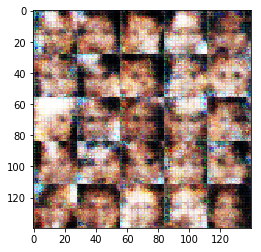

Epoch 1/1... Batch 910... Discriminator Loss: 0.0129... Generator Loss: 6.1403
Epoch 1/1... Batch 920... Discriminator Loss: 0.0294... Generator Loss: 4.7276
Epoch 1/1... Batch 930... Discriminator Loss: 0.0094... Generator Loss: 5.7385
Epoch 1/1... Batch 940... Discriminator Loss: 0.0093... Generator Loss: 5.9961
Epoch 1/1... Batch 950... Discriminator Loss: 0.0081... Generator Loss: 6.2213
Epoch 1/1... Batch 960... Discriminator Loss: 0.0132... Generator Loss: 5.5482
Epoch 1/1... Batch 970... Discriminator Loss: 0.0111... Generator Loss: 5.3592
Epoch 1/1... Batch 980... Discriminator Loss: 0.0031... Generator Loss: 6.5840
Epoch 1/1... Batch 990... Discriminator Loss: 0.0123... Generator Loss: 5.6518
Epoch 1/1... Batch 1000... Discriminator Loss: 0.0073... Generator Loss: 5.7369


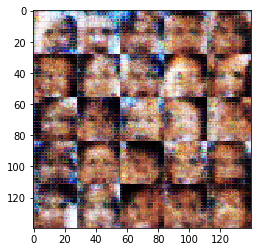

Epoch 1/1... Batch 1010... Discriminator Loss: 0.0063... Generator Loss: 6.3304
Epoch 1/1... Batch 1020... Discriminator Loss: 0.0064... Generator Loss: 6.0273
Epoch 1/1... Batch 1030... Discriminator Loss: 0.0059... Generator Loss: 6.3139
Epoch 1/1... Batch 1040... Discriminator Loss: 0.0074... Generator Loss: 5.7850
Epoch 1/1... Batch 1050... Discriminator Loss: 0.0097... Generator Loss: 6.1241
Epoch 1/1... Batch 1060... Discriminator Loss: 0.0029... Generator Loss: 6.8521
Epoch 1/1... Batch 1070... Discriminator Loss: 0.0089... Generator Loss: 6.1530
Epoch 1/1... Batch 1080... Discriminator Loss: 0.0075... Generator Loss: 6.1218
Epoch 1/1... Batch 1090... Discriminator Loss: 0.1744... Generator Loss: 3.1774
Epoch 1/1... Batch 1100... Discriminator Loss: 0.0117... Generator Loss: 5.6194


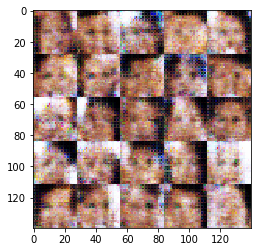

Epoch 1/1... Batch 1110... Discriminator Loss: 0.0274... Generator Loss: 5.2317
Epoch 1/1... Batch 1120... Discriminator Loss: 0.0232... Generator Loss: 5.2013
Epoch 1/1... Batch 1130... Discriminator Loss: 0.0159... Generator Loss: 5.1769
Epoch 1/1... Batch 1140... Discriminator Loss: 0.0073... Generator Loss: 5.9345
Epoch 1/1... Batch 1150... Discriminator Loss: 0.0098... Generator Loss: 5.7551
Epoch 1/1... Batch 1160... Discriminator Loss: 0.0112... Generator Loss: 5.5736
Epoch 1/1... Batch 1170... Discriminator Loss: 0.0294... Generator Loss: 4.2824
Epoch 1/1... Batch 1180... Discriminator Loss: 0.0141... Generator Loss: 4.8258
Epoch 1/1... Batch 1190... Discriminator Loss: 0.0121... Generator Loss: 5.4282
Epoch 1/1... Batch 1200... Discriminator Loss: 0.0124... Generator Loss: 6.2302


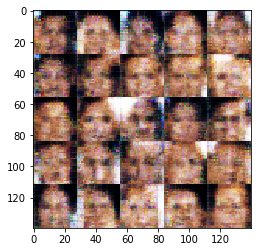

Epoch 1/1... Batch 1210... Discriminator Loss: 0.0119... Generator Loss: 5.3464
Epoch 1/1... Batch 1220... Discriminator Loss: 0.1404... Generator Loss: 2.6843
Epoch 1/1... Batch 1230... Discriminator Loss: 0.0068... Generator Loss: 6.9587
Epoch 1/1... Batch 1240... Discriminator Loss: 0.0112... Generator Loss: 5.3432
Epoch 1/1... Batch 1250... Discriminator Loss: 0.0173... Generator Loss: 5.4016
Epoch 1/1... Batch 1260... Discriminator Loss: 0.0068... Generator Loss: 6.0714
Epoch 1/1... Batch 1270... Discriminator Loss: 0.0104... Generator Loss: 6.0815
Epoch 1/1... Batch 1280... Discriminator Loss: 0.0084... Generator Loss: 6.1413
Epoch 1/1... Batch 1290... Discriminator Loss: 0.1291... Generator Loss: 2.7122
Epoch 1/1... Batch 1300... Discriminator Loss: 0.0115... Generator Loss: 6.4434


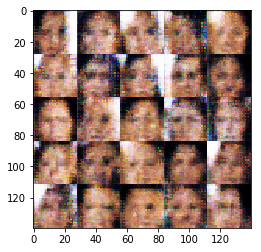

Epoch 1/1... Batch 1310... Discriminator Loss: 0.0103... Generator Loss: 5.8735
Epoch 1/1... Batch 1320... Discriminator Loss: 0.0124... Generator Loss: 7.6317
Epoch 1/1... Batch 1330... Discriminator Loss: 1.0258... Generator Loss: 1.0871
Epoch 1/1... Batch 1340... Discriminator Loss: 0.0111... Generator Loss: 5.8252
Epoch 1/1... Batch 1350... Discriminator Loss: 0.0065... Generator Loss: 7.3312
Epoch 1/1... Batch 1360... Discriminator Loss: 0.0554... Generator Loss: 4.9755
Epoch 1/1... Batch 1370... Discriminator Loss: 0.0082... Generator Loss: 6.2362
Epoch 1/1... Batch 1380... Discriminator Loss: 0.0150... Generator Loss: 6.9832
Epoch 1/1... Batch 1390... Discriminator Loss: 0.0555... Generator Loss: 4.7948
Epoch 1/1... Batch 1400... Discriminator Loss: 0.0345... Generator Loss: 4.8859


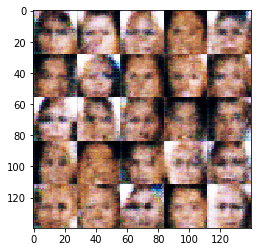

Epoch 1/1... Batch 1410... Discriminator Loss: 0.0232... Generator Loss: 4.6423
Epoch 1/1... Batch 1420... Discriminator Loss: 0.0252... Generator Loss: 5.3483
Epoch 1/1... Batch 1430... Discriminator Loss: 0.0251... Generator Loss: 5.5530
Epoch 1/1... Batch 1440... Discriminator Loss: 0.0198... Generator Loss: 4.8348
Epoch 1/1... Batch 1450... Discriminator Loss: 0.0150... Generator Loss: 5.9368
Epoch 1/1... Batch 1460... Discriminator Loss: 0.0155... Generator Loss: 5.2681
Epoch 1/1... Batch 1470... Discriminator Loss: 0.0075... Generator Loss: 5.8898
Epoch 1/1... Batch 1480... Discriminator Loss: 0.5092... Generator Loss: 1.9141
Epoch 1/1... Batch 1490... Discriminator Loss: 0.0193... Generator Loss: 5.6996
Epoch 1/1... Batch 1500... Discriminator Loss: 0.0112... Generator Loss: 6.1828


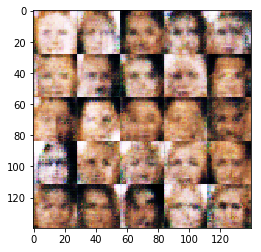

Epoch 1/1... Batch 1510... Discriminator Loss: 0.0229... Generator Loss: 4.8648
Epoch 1/1... Batch 1520... Discriminator Loss: 0.0288... Generator Loss: 5.4645
Epoch 1/1... Batch 1530... Discriminator Loss: 0.0206... Generator Loss: 5.5801
Epoch 1/1... Batch 1540... Discriminator Loss: 0.0247... Generator Loss: 5.4076
Epoch 1/1... Batch 1550... Discriminator Loss: 0.0307... Generator Loss: 4.4559
Epoch 1/1... Batch 1560... Discriminator Loss: 0.0222... Generator Loss: 4.8298
Epoch 1/1... Batch 1570... Discriminator Loss: 0.0213... Generator Loss: 6.1392
Epoch 1/1... Batch 1580... Discriminator Loss: 0.0420... Generator Loss: 4.6197
Epoch 1/1... Batch 1590... Discriminator Loss: 0.0235... Generator Loss: 5.6762
Epoch 1/1... Batch 1600... Discriminator Loss: 0.0695... Generator Loss: 5.9751


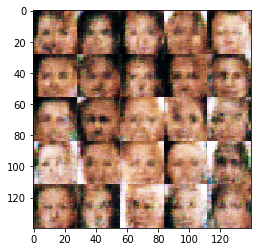

Epoch 1/1... Batch 1610... Discriminator Loss: 0.0395... Generator Loss: 4.5228
Epoch 1/1... Batch 1620... Discriminator Loss: 0.0147... Generator Loss: 5.5778
Epoch 1/1... Batch 1630... Discriminator Loss: 0.0050... Generator Loss: 6.7923
Epoch 1/1... Batch 1640... Discriminator Loss: 0.0056... Generator Loss: 6.5298
Epoch 1/1... Batch 1650... Discriminator Loss: 0.0303... Generator Loss: 5.6593
Epoch 1/1... Batch 1660... Discriminator Loss: 0.0153... Generator Loss: 5.6178
Epoch 1/1... Batch 1670... Discriminator Loss: 0.0121... Generator Loss: 5.9835
Epoch 1/1... Batch 1680... Discriminator Loss: 0.0089... Generator Loss: 6.1090
Epoch 1/1... Batch 1690... Discriminator Loss: 0.0253... Generator Loss: 5.1948
Epoch 1/1... Batch 1700... Discriminator Loss: 0.0115... Generator Loss: 5.7089


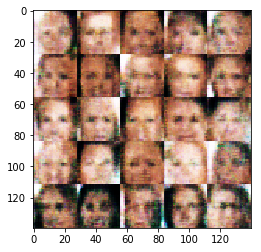

Epoch 1/1... Batch 1710... Discriminator Loss: 0.0289... Generator Loss: 5.2399
Epoch 1/1... Batch 1720... Discriminator Loss: 0.0302... Generator Loss: 4.8323
Epoch 1/1... Batch 1730... Discriminator Loss: 0.0405... Generator Loss: 5.2472
Epoch 1/1... Batch 1740... Discriminator Loss: 0.0332... Generator Loss: 4.1160
Epoch 1/1... Batch 1750... Discriminator Loss: 0.0248... Generator Loss: 4.9938
Epoch 1/1... Batch 1760... Discriminator Loss: 0.0149... Generator Loss: 5.3060
Epoch 1/1... Batch 1770... Discriminator Loss: 0.0086... Generator Loss: 5.3226
Epoch 1/1... Batch 1780... Discriminator Loss: 0.0287... Generator Loss: 4.8791
Epoch 1/1... Batch 1790... Discriminator Loss: 0.0202... Generator Loss: 5.5449
Epoch 1/1... Batch 1800... Discriminator Loss: 0.0133... Generator Loss: 6.5358


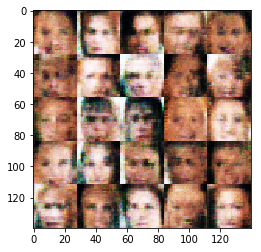

Epoch 1/1... Batch 1810... Discriminator Loss: 0.0124... Generator Loss: 5.3881
Epoch 1/1... Batch 1820... Discriminator Loss: 0.0072... Generator Loss: 6.2539
Epoch 1/1... Batch 1830... Discriminator Loss: 0.0093... Generator Loss: 5.4395
Epoch 1/1... Batch 1840... Discriminator Loss: 0.0322... Generator Loss: 4.4192
Epoch 1/1... Batch 1850... Discriminator Loss: 0.0252... Generator Loss: 4.5755
Epoch 1/1... Batch 1860... Discriminator Loss: 0.0256... Generator Loss: 4.9153
Epoch 1/1... Batch 1870... Discriminator Loss: 0.0210... Generator Loss: 5.3492
Epoch 1/1... Batch 1880... Discriminator Loss: 0.0051... Generator Loss: 6.4426
Epoch 1/1... Batch 1890... Discriminator Loss: 0.0270... Generator Loss: 4.7867
Epoch 1/1... Batch 1900... Discriminator Loss: 0.0243... Generator Loss: 4.5773


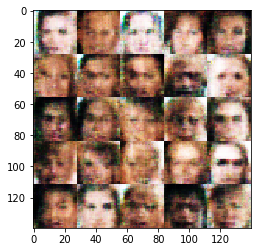

Epoch 1/1... Batch 1910... Discriminator Loss: 0.0547... Generator Loss: 3.9464
Epoch 1/1... Batch 1920... Discriminator Loss: 0.0177... Generator Loss: 6.7491
Epoch 1/1... Batch 1930... Discriminator Loss: 0.0512... Generator Loss: 4.1657
Epoch 1/1... Batch 1940... Discriminator Loss: 0.0393... Generator Loss: 4.6990
Epoch 1/1... Batch 1950... Discriminator Loss: 0.0971... Generator Loss: 3.0390
Epoch 1/1... Batch 1960... Discriminator Loss: 0.0416... Generator Loss: 5.2318
Epoch 1/1... Batch 1970... Discriminator Loss: 0.0282... Generator Loss: 4.5785
Epoch 1/1... Batch 1980... Discriminator Loss: 0.0239... Generator Loss: 4.6005
Epoch 1/1... Batch 1990... Discriminator Loss: 0.0151... Generator Loss: 5.0058
Epoch 1/1... Batch 2000... Discriminator Loss: 0.0169... Generator Loss: 4.6843


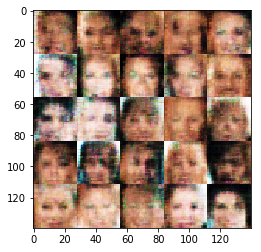

Epoch 1/1... Batch 2010... Discriminator Loss: 0.0253... Generator Loss: 5.2788
Epoch 1/1... Batch 2020... Discriminator Loss: 0.0214... Generator Loss: 4.4643
Epoch 1/1... Batch 2030... Discriminator Loss: 0.0153... Generator Loss: 5.4175
Epoch 1/1... Batch 2040... Discriminator Loss: 0.0113... Generator Loss: 5.3124
Epoch 1/1... Batch 2050... Discriminator Loss: 0.0685... Generator Loss: 3.9093
Epoch 1/1... Batch 2060... Discriminator Loss: 0.2830... Generator Loss: 2.3205
Epoch 1/1... Batch 2070... Discriminator Loss: 0.0187... Generator Loss: 5.3405
Epoch 1/1... Batch 2080... Discriminator Loss: 0.0788... Generator Loss: 3.8672
Epoch 1/1... Batch 2090... Discriminator Loss: 0.0221... Generator Loss: 4.5683
Epoch 1/1... Batch 2100... Discriminator Loss: 0.0115... Generator Loss: 5.2408


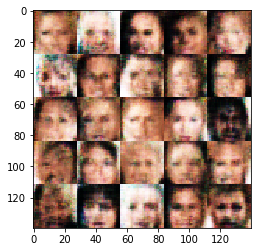

Epoch 1/1... Batch 2110... Discriminator Loss: 0.0309... Generator Loss: 4.0356
Epoch 1/1... Batch 2120... Discriminator Loss: 0.0452... Generator Loss: 4.8795
Epoch 1/1... Batch 2130... Discriminator Loss: 0.0258... Generator Loss: 5.2301
Epoch 1/1... Batch 2140... Discriminator Loss: 0.1087... Generator Loss: 4.9948
Epoch 1/1... Batch 2150... Discriminator Loss: 0.0278... Generator Loss: 5.7029
Epoch 1/1... Batch 2160... Discriminator Loss: 0.0609... Generator Loss: 4.4378
Epoch 1/1... Batch 2170... Discriminator Loss: 0.0366... Generator Loss: 5.1216
Epoch 1/1... Batch 2180... Discriminator Loss: 0.0416... Generator Loss: 5.5019
Epoch 1/1... Batch 2190... Discriminator Loss: 0.0452... Generator Loss: 5.2273
Epoch 1/1... Batch 2200... Discriminator Loss: 0.0243... Generator Loss: 4.9779


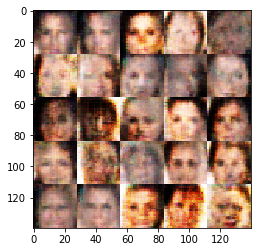

Epoch 1/1... Batch 2210... Discriminator Loss: 0.0296... Generator Loss: 5.3193
Epoch 1/1... Batch 2220... Discriminator Loss: 0.0348... Generator Loss: 4.7146
Epoch 1/1... Batch 2230... Discriminator Loss: 0.0578... Generator Loss: 4.1112
Epoch 1/1... Batch 2240... Discriminator Loss: 0.0698... Generator Loss: 3.2623
Epoch 1/1... Batch 2250... Discriminator Loss: 0.0234... Generator Loss: 5.5809
Epoch 1/1... Batch 2260... Discriminator Loss: 0.0378... Generator Loss: 4.5778
Epoch 1/1... Batch 2270... Discriminator Loss: 0.0590... Generator Loss: 3.8106
Epoch 1/1... Batch 2280... Discriminator Loss: 0.1841... Generator Loss: 5.9616
Epoch 1/1... Batch 2290... Discriminator Loss: 0.0226... Generator Loss: 6.4381
Epoch 1/1... Batch 2300... Discriminator Loss: 0.0704... Generator Loss: 6.8023


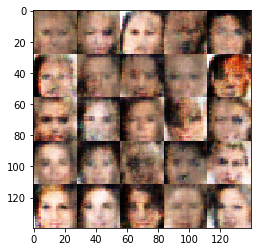

Epoch 1/1... Batch 2310... Discriminator Loss: 0.0678... Generator Loss: 4.4471
Epoch 1/1... Batch 2320... Discriminator Loss: 0.6669... Generator Loss: 1.1401
Epoch 1/1... Batch 2330... Discriminator Loss: 0.0439... Generator Loss: 4.8671
Epoch 1/1... Batch 2340... Discriminator Loss: 0.0291... Generator Loss: 4.8089
Epoch 1/1... Batch 2350... Discriminator Loss: 0.0311... Generator Loss: 5.2304
Epoch 1/1... Batch 2360... Discriminator Loss: 0.0736... Generator Loss: 3.3174
Epoch 1/1... Batch 2370... Discriminator Loss: 0.0594... Generator Loss: 4.1630
Epoch 1/1... Batch 2380... Discriminator Loss: 0.2338... Generator Loss: 2.0858
Epoch 1/1... Batch 2390... Discriminator Loss: 0.0390... Generator Loss: 4.2252
Epoch 1/1... Batch 2400... Discriminator Loss: 0.0459... Generator Loss: 4.2618


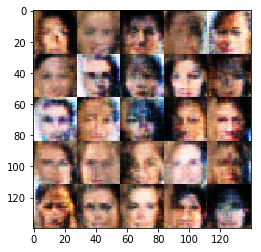

Epoch 1/1... Batch 2410... Discriminator Loss: 0.1331... Generator Loss: 2.8814
Epoch 1/1... Batch 2420... Discriminator Loss: 0.0899... Generator Loss: 3.1360
Epoch 1/1... Batch 2430... Discriminator Loss: 0.0258... Generator Loss: 4.6651
Epoch 1/1... Batch 2440... Discriminator Loss: 0.0313... Generator Loss: 4.6741
Epoch 1/1... Batch 2450... Discriminator Loss: 0.0812... Generator Loss: 3.9121
Epoch 1/1... Batch 2460... Discriminator Loss: 0.1074... Generator Loss: 3.2904
Epoch 1/1... Batch 2470... Discriminator Loss: 0.1086... Generator Loss: 3.3407
Epoch 1/1... Batch 2480... Discriminator Loss: 0.0937... Generator Loss: 4.3062
Epoch 1/1... Batch 2490... Discriminator Loss: 0.7838... Generator Loss: 0.9984
Epoch 1/1... Batch 2500... Discriminator Loss: 0.0871... Generator Loss: 3.5265


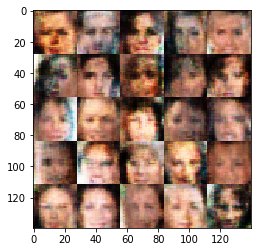

Epoch 1/1... Batch 2510... Discriminator Loss: 0.0949... Generator Loss: 4.9254
Epoch 1/1... Batch 2520... Discriminator Loss: 0.4003... Generator Loss: 1.6015
Epoch 1/1... Batch 2530... Discriminator Loss: 0.1476... Generator Loss: 3.0194
Epoch 1/1... Batch 2540... Discriminator Loss: 0.0515... Generator Loss: 4.4663
Epoch 1/1... Batch 2550... Discriminator Loss: 0.0795... Generator Loss: 5.0949
Epoch 1/1... Batch 2560... Discriminator Loss: 0.1380... Generator Loss: 3.0111
Epoch 1/1... Batch 2570... Discriminator Loss: 0.0780... Generator Loss: 3.6768
Epoch 1/1... Batch 2580... Discriminator Loss: 0.0871... Generator Loss: 3.8561
Epoch 1/1... Batch 2590... Discriminator Loss: 0.1012... Generator Loss: 3.4636
Epoch 1/1... Batch 2600... Discriminator Loss: 0.4160... Generator Loss: 1.6332


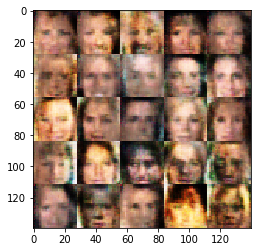

Epoch 1/1... Batch 2610... Discriminator Loss: 0.0581... Generator Loss: 4.5011
Epoch 1/1... Batch 2620... Discriminator Loss: 0.0452... Generator Loss: 4.6973
Epoch 1/1... Batch 2630... Discriminator Loss: 0.1077... Generator Loss: 3.1704
Epoch 1/1... Batch 2640... Discriminator Loss: 0.0655... Generator Loss: 4.2522
Epoch 1/1... Batch 2650... Discriminator Loss: 0.0954... Generator Loss: 3.4431
Epoch 1/1... Batch 2660... Discriminator Loss: 0.0686... Generator Loss: 3.8087
Epoch 1/1... Batch 2670... Discriminator Loss: 0.1558... Generator Loss: 6.6840
Epoch 1/1... Batch 2680... Discriminator Loss: 0.1185... Generator Loss: 3.3112
Epoch 1/1... Batch 2690... Discriminator Loss: 0.0825... Generator Loss: 3.3266
Epoch 1/1... Batch 2700... Discriminator Loss: 0.1044... Generator Loss: 3.6220


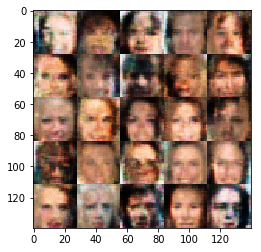

Epoch 1/1... Batch 2710... Discriminator Loss: 0.1100... Generator Loss: 3.5041
Epoch 1/1... Batch 2720... Discriminator Loss: 0.0931... Generator Loss: 3.2334
Epoch 1/1... Batch 2730... Discriminator Loss: 0.0920... Generator Loss: 3.3507
Epoch 1/1... Batch 2740... Discriminator Loss: 0.0768... Generator Loss: 3.5793
Epoch 1/1... Batch 2750... Discriminator Loss: 0.0678... Generator Loss: 3.8503
Epoch 1/1... Batch 2760... Discriminator Loss: 0.0694... Generator Loss: 4.1807
Epoch 1/1... Batch 2770... Discriminator Loss: 0.0405... Generator Loss: 4.4390
Epoch 1/1... Batch 2780... Discriminator Loss: 0.1695... Generator Loss: 2.3995
Epoch 1/1... Batch 2790... Discriminator Loss: 0.0669... Generator Loss: 3.8108
Epoch 1/1... Batch 2800... Discriminator Loss: 0.2279... Generator Loss: 2.0606


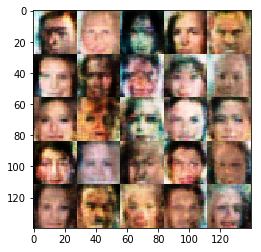

Epoch 1/1... Batch 2810... Discriminator Loss: 0.5878... Generator Loss: 1.6413
Epoch 1/1... Batch 2820... Discriminator Loss: 0.1413... Generator Loss: 2.9889
Epoch 1/1... Batch 2830... Discriminator Loss: 0.1137... Generator Loss: 3.3324
Epoch 1/1... Batch 2840... Discriminator Loss: 0.1136... Generator Loss: 3.9315
Epoch 1/1... Batch 2850... Discriminator Loss: 0.0905... Generator Loss: 4.0863
Epoch 1/1... Batch 2860... Discriminator Loss: 0.0506... Generator Loss: 3.8123
Epoch 1/1... Batch 2870... Discriminator Loss: 0.0596... Generator Loss: 3.8611
Epoch 1/1... Batch 2880... Discriminator Loss: 0.2398... Generator Loss: 5.0386
Epoch 1/1... Batch 2890... Discriminator Loss: 0.1204... Generator Loss: 3.2332
Epoch 1/1... Batch 2900... Discriminator Loss: 0.0737... Generator Loss: 3.6800


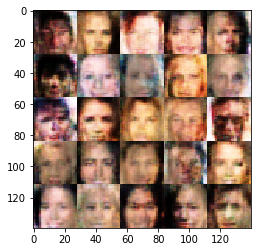

Epoch 1/1... Batch 2910... Discriminator Loss: 0.1305... Generator Loss: 4.2795
Epoch 1/1... Batch 2920... Discriminator Loss: 0.1124... Generator Loss: 4.7055
Epoch 1/1... Batch 2930... Discriminator Loss: 0.1293... Generator Loss: 2.8515
Epoch 1/1... Batch 2940... Discriminator Loss: 0.1733... Generator Loss: 2.4142
Epoch 1/1... Batch 2950... Discriminator Loss: 0.0506... Generator Loss: 4.3777
Epoch 1/1... Batch 2960... Discriminator Loss: 0.0899... Generator Loss: 4.0109
Epoch 1/1... Batch 2970... Discriminator Loss: 0.0883... Generator Loss: 3.2208
Epoch 1/1... Batch 2980... Discriminator Loss: 0.0962... Generator Loss: 3.2982
Epoch 1/1... Batch 2990... Discriminator Loss: 0.0854... Generator Loss: 3.5086
Epoch 1/1... Batch 3000... Discriminator Loss: 0.0530... Generator Loss: 3.8758


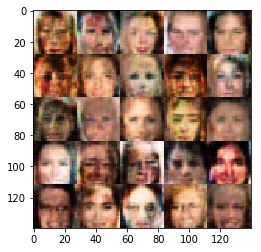

Epoch 1/1... Batch 3010... Discriminator Loss: 0.1052... Generator Loss: 4.2262
Epoch 1/1... Batch 3020... Discriminator Loss: 0.0533... Generator Loss: 4.3312
Epoch 1/1... Batch 3030... Discriminator Loss: 0.1816... Generator Loss: 3.6754
Epoch 1/1... Batch 3040... Discriminator Loss: 0.0886... Generator Loss: 3.4787
Epoch 1/1... Batch 3050... Discriminator Loss: 0.1065... Generator Loss: 3.1716
Epoch 1/1... Batch 3060... Discriminator Loss: 0.1017... Generator Loss: 3.1777
Epoch 1/1... Batch 3070... Discriminator Loss: 0.1073... Generator Loss: 3.4392
Epoch 1/1... Batch 3080... Discriminator Loss: 0.0678... Generator Loss: 3.2873
Epoch 1/1... Batch 3090... Discriminator Loss: 0.1202... Generator Loss: 3.0315
Epoch 1/1... Batch 3100... Discriminator Loss: 0.1111... Generator Loss: 2.9494


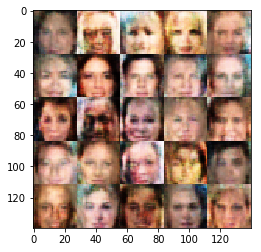

Epoch 1/1... Batch 3110... Discriminator Loss: 0.0738... Generator Loss: 3.5031
Epoch 1/1... Batch 3120... Discriminator Loss: 0.0818... Generator Loss: 3.5175
Epoch 1/1... Batch 3130... Discriminator Loss: 0.1824... Generator Loss: 4.6636
Epoch 1/1... Batch 3140... Discriminator Loss: 0.0678... Generator Loss: 3.8403
Epoch 1/1... Batch 3150... Discriminator Loss: 1.0614... Generator Loss: 0.6885
Epoch 1/1... Batch 3160... Discriminator Loss: 0.0711... Generator Loss: 4.0901


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.